# Import Module and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [2]:
event_data = pd.read_csv('data/all_user_event_data.csv')
profile_data = pd.read_csv('data/all_user_profile_data.csv')
repo_data = pd.read_csv('data/all_user_repo_data.csv')
starred_data = pd.read_csv('data/all_user_starred_data.csv')

In [3]:
def SelectNumericColumn(df):
    return df.select_dtypes(include=[np.number])

In [4]:
def PlotCorr(df, title):
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title(title)
    plt.show()
    return corr

# Data Analysis

<b>Objective</b>: Get insights into the GitHub activity patterns of GitHub users with a high follower count.

The following steps will be undertaken to analyze the relationships:

<ul>
    <li>1. Determine if there are any disparities in the data fields between users with a high number of followers and those with fewer followers.</li>
    <li>2. If differences are found, conduct a detailed analysis to understand how these fields affect the number of followers and the nature of their influence.</li>
    <li>3. Visualize the data and perform statistical tests with a focus on significant values to better understand the patterns and trends.</li>
    <li>4. Repeat steps 1-3 for each data field.</li>
    <li>5. Compile and summarize the findings from each iteration.</li>
</ul>

## Selecting High-Follower User

In [5]:
threshold = 4 # Reasons for choosing threshold = 4 can be found in EDA notebook
high_follower_users = profile_data[profile_data['followers'] > threshold]

In [6]:
high_follower_users.head()

,user_alias,type,hireable,location,followers,following,public_repos,public_gists,created_at,updated_at
2,usr2,User,NaN,Karachi,13.0,23.0,44.0,NaN,2023-01-03T13:56:42Z,2023-12-24T05:10:36Z
10,usr10,User,True,Ho Chi Minh City/Viet Nam,126.0,170.0,50.0,17.0,2015-05-07T09:55:21Z,2023-12-14T15:56:05Z
11,usr11,User,NaN,Valencia/Spain,7.0,4.0,18.0,NaN,2019-03-04T16:50:46Z,2023-11-12T21:11:04Z
14,usr14,User,NaN,Athens/Greece,8.0,14.0,7.0,NaN,2020-11-11T20:12:32Z,2024-01-04T14:49:09Z
19,usr19,User,True,Rajshahi/Bangladesh.,15.0,27.0,18.0,NaN,2017-04-16T11:38:35Z,2022-04-07T17:56:46Z


In [7]:
len(high_follower_users)

2988

In [8]:
high_follower_aliases = high_follower_users['user_alias']

In [9]:
high_follower_aliases.head()

2      usr2
10    usr10
11    usr11
14    usr14
19    usr19
Name: user_alias, dtype: object

In [10]:
high_follower_event_data = event_data[event_data['user_alias'].isin(high_follower_aliases)]
high_follower_repo_data = repo_data[repo_data['user_alias'].isin(high_follower_aliases)]
high_follower_starred_data = starred_data[starred_data['user_alias'].isin(high_follower_aliases)]

## Analyze The Relationship

### Profile Data

#### Correlation Analysis

In [11]:
profile_data.head()

,user_alias,type,hireable,location,followers,following,public_repos,public_gists,created_at,updated_at
0,usr0,User,NaN,NaN,2.0,7.0,43.0,NaN,2020-09-07T23:54:51Z,2023-10-05T18:16:01Z
1,usr1,User,NaN,Tbilisi,3.0,4.0,16.0,NaN,2011-04-16T12:30:37Z,2024-01-08T13:45:16Z
2,usr2,User,NaN,Karachi,13.0,23.0,44.0,NaN,2023-01-03T13:56:42Z,2023-12-24T05:10:36Z
3,usr3,User,True,Karachi,NaN,NaN,5.0,NaN,2021-09-24T09:04:40Z,2023-05-02T19:11:00Z
4,usr4,User,NaN,NaN,1.0,NaN,2.0,NaN,2022-10-07T11:01:08Z,2023-12-07T20:03:36Z


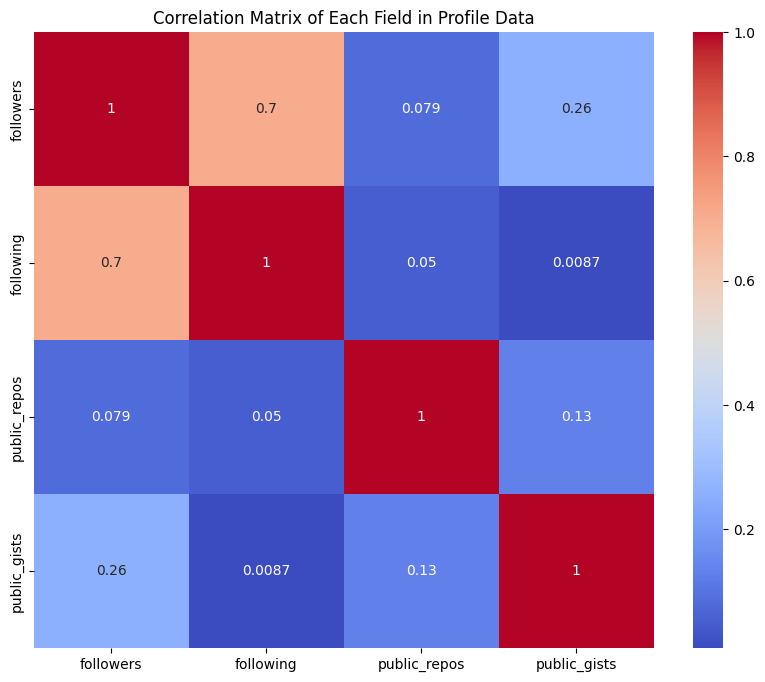

In [12]:
corr = PlotCorr(SelectNumericColumn(profile_data), title='Correlation Matrix of Each Field in Profile Data')

In [13]:
corr

,followers,following,public_repos,public_gists
followers,1.000000,0.702345,0.079321,0.255694
following,0.702345,1.000000,0.050371,0.008656
public_repos,0.079321,0.050371,1.000000,0.129804
public_gists,0.255694,0.008656,0.129804,1.000000


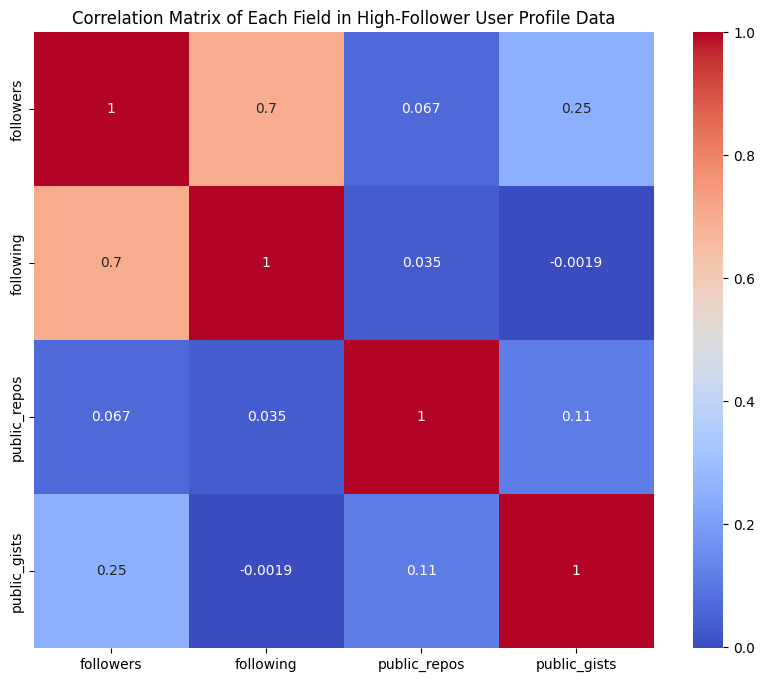

In [14]:
corr = PlotCorr(SelectNumericColumn(high_follower_users), title='Correlation Matrix of Each Field in High-Follower User Profile Data')

In [15]:
corr

,followers,following,public_repos,public_gists
followers,1.000000,0.700527,0.067412,0.251672
following,0.700527,1.000000,0.034955,-0.001934
public_repos,0.067412,0.034955,1.000000,0.110392
public_gists,0.251672,-0.001934,0.110392,1.000000


By analyzing the Correlation Matrix of each field in the profile data of all users and specifically high-follower users, we can observe a significant correlation between the `following` and `followers` fields. A correlation coefficient of 0.702345 and 0.700527 indicates a strong positive relationship, suggesting that as the number of users one follows increases, so does the number of followers they have.

#### Regression Analysis of `following` and `followers`

In [16]:
profile_data = profile_data.dropna(subset=['following', 'followers'])

In [17]:
X = profile_data['following']
y = profile_data['followers']
X1 = sm.add_constant(X)

model = sm.OLS(y, X1)
results = model.fit()

In [18]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     5080.
Date:                Mon, 29 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:54:28   Log-Likelihood:                -35017.
No. Observations:                5220   AIC:                         7.004e+04
Df Residuals:                    5218   BIC:                         7.005e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7228      2.759      2.074      0.038       0.314      11.132
following      0.8106      0.011     71.272      0.000       0.788       0.833
==============================================================================
Omnibus:                    12617.647   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        203386733.847
Skew:                          24.720   Prob(JB):                         0.00
Kurtosis:                     968.747   Cond. No.                         244.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared = 0.493, This is a statistical measure that represents the proportion of the variance for the dependent variable that's explained by the independent variable. Meaning that approximately 49.3% of the variability in `followers` can be explained by `following`.

F-statistic = 5080, This is a measure of how significant the fit of the model is.

Prob (F-statistic) = 0.00 (The associated p-value) is less than 0.05 means that the independent variable, `following`, is a statistically significant predictor of `followers`.

coef for `following` = 0.8106, This is the change in the `followers` variable for a one-unit change in the `following` variable, holding all other variables constant. In this case, for each additional user that someone follows, their followers will increase by about 0.81.

### Event Data

In [19]:
event_data.head()

,user_alias,event_type,created_at
0,usr1,PushEvent,2023-10-31T17:57:39Z
1,usr1,CreateEvent,2023-10-30T18:13:26Z
2,usr1,CreateEvent,2023-10-30T17:53:32Z
3,usr2,CreateEvent,2024-01-08T17:29:08Z
4,usr2,CreateEvent,2024-01-08T17:27:38Z


...